In [12]:
import pandas as pd

from shapely.geometry import Point, Polygon

import numpy as np

import random

import pulp

import networkx as nx

import math

import h3

import os,sys

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import copy

sys.path.append('./Class/')

from Hexagon import Hexagon



## 01 Parameters

In [13]:
'''Systemic paths'''

Load_path='./NYC_Network/'



'''Time step'''

Start_step=2520 # Start stamp 

End_step=3600 # End stamp 



'''Initial number of drivers'''

ini_num=150

arrival_rate=1 #pre ten seconds


'''Network data'''

'''Grid-related data'''

Grid_list=np.load(os.path.join(Load_path,'Grids.npy'),allow_pickle=True)

Grid_Point=np.load(os.path.join(Load_path,'Grid_Point.npy'),allow_pickle=True).item()

'''Point-related data'''

Points_list=np.load(os.path.join(Load_path,'Points_list.npy'),allow_pickle=True)

Link_Point=np.load(os.path.join(Load_path,'Link_Point.npy'),allow_pickle=True).item()

Point_coordinate=np.load(os.path.join(Load_path,'Point_coordinate.npy'),allow_pickle=True).item()

Point_Grid=np.load(os.path.join(Load_path,'Point_Grid.npy'),allow_pickle=True).item()

'''Hexagonal region'''

resolution=9

Hex=Hexagon(resolution)




## 02 Generate Driver

In [15]:
'''Initial distribution'''

Driver_num=copy.deepcopy(ini_num)

Driver_list=['D'+str(i) for i in range(Driver_num)]

Driver_df=pd.DataFrame(Driver_list,columns=['Driver_id'])

Driver_df['Grid']=Driver_df.apply(lambda x:str(random.choice(Grid_list)),axis=1)

Driver_df['Point']=Driver_df.apply(lambda x:[p for p in h3.h3_to_geo(x['Grid'])],axis=1)

Driver_df['Reposition_Point']=Driver_df.apply(lambda x:x['Point'],axis=1)

Driver_df['Reposition_Grid']=Driver_df.apply(lambda x:x['Grid'],axis=1)

Driver_df['Step']=Start_step

Driver_df['Order_id']='Idle'

Driver_df=Driver_df[['Driver_id','Order_id','Step','Point','Grid','Reposition_Point','Reposition_Grid']]

'''First hour distribution'''


for step in range(Start_step,Start_step+6*60):

    for i in range(arrival_rate):

        Added_item={}

        driver_id='D'+str(Driver_num)

        Added_item['Driver_id']=driver_id

        Added_item['Order_id']='Idle'

        Added_item['Step']=step

        Added_item['Grid']=str(random.choice(Grid_list))

        Added_item['Point']=h3.h3_to_geo(Added_item['Grid'])

        Added_item['Reposition_Point']=Added_item['Point']

        Added_item['Reposition_Grid']= Added_item['Grid']

        Driver_df=Driver_df.append(Added_item, ignore_index=True)

        Driver_num+=1

        
Driver_df

,Driver_id,Order_id,Step,Point,Grid,Reposition_Point,Reposition_Grid
0,D0,Idle,2520,"[40.85735318757529, -73.92559318149429]",892a100ae8fffff,"[40.85735318757529, -73.92559318149429]",892a100ae8fffff
1,D1,Idle,2520,"[40.81672564793101, -73.96048635474924]",892a1008c03ffff,"[40.81672564793101, -73.96048635474924]",892a1008c03ffff
2,D2,Idle,2520,"[40.72552009875161, -74.00830230921224]",892a1072c57ffff,"[40.72552009875161, -74.00830230921224]",892a1072c57ffff
3,D3,Idle,2520,"[40.79230724465317, -73.98310565091663]",892a1008863ffff,"[40.79230724465317, -73.98310565091663]",892a1008863ffff
4,D4,Idle,2520,"[40.77915384672378, -73.98044924503581]",892a1008bbbffff,"[40.77915384672378, -73.98044924503581]",892a1008bbbffff
...,...,...,...,...,...,...,...
505,D505,Idle,2875,"(40.83011475573099, -73.95457284997781)",892a100aa63ffff,"(40.83011475573099, -73.95457284997781)",892a100aa63ffff
506,D506,Idle,2876,"(40.79885307565972, -73.93622927143312)",892a1008dbbffff,"(40.79885307565972, -73.93622927143312)",892a1008dbbffff
507,D507,Idle,2877,"(40.734079205547125, -73.98510699874309)",892a100d223ffff,"(40.734079205547125, -73.98510699874309)",892a100d223ffff
508,D508,Idle,2878,"(40.73184224228762, -73.97004368864602)",892a100d3d7ffff,"(40.73184224228762, -73.97004368864602)",892a100d3d7ffff


## 03 Culmulative drivers

C:\Users\yyan2437\AppData\Local\Temp/ipykernel_5148/2967941334.py:95: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  axs.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
C:\Users\yyan2437\AppData\Local\Temp/ipykernel_5148/2967941334.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\


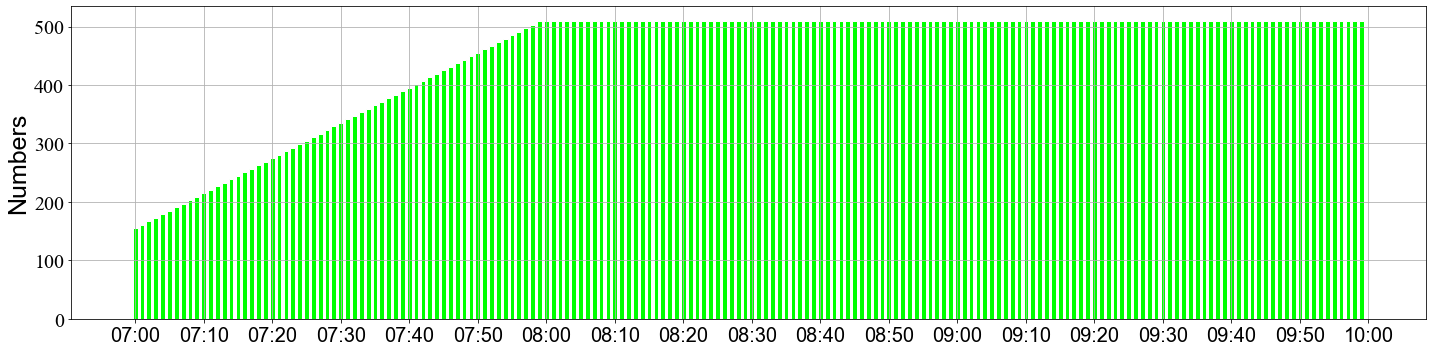

In [28]:
def Get_minute(step):
    
    return int((step-Start_step)/6)

Driver_STAT=Driver_df.groupby(['Step']).count()

Driver_STAT['Step']=Driver_STAT.index

Driver_STAT=Driver_STAT.reset_index(drop=True)

Driver_STAT['Driver_num']=ini_num

for idx,col in Driver_STAT.iterrows():
    
    if idx!=0:
    
        Driver_STAT.loc[idx,'Driver_num']=Driver_STAT.loc[idx-1,'Driver_num']+Driver_STAT.loc[idx,'Driver_id']

Driver_STAT['minute']=Driver_STAT.apply(lambda x:Get_minute(x['Step']),axis=1)

Driver_STAT=Driver_STAT.drop_duplicates(subset=['minute'], keep='last')

Driver_STAT=Driver_STAT.reset_index(drop=True)

Driver_STAT=Driver_STAT[['minute','Driver_num']]

Driver_STAT[['Driver_num']] = Driver_STAT[['Driver_num']].astype(int)

for i in range(120):
    
    minute = Driver_STAT.minute.to_list()[-1]+1
    
    Driver_num = Driver_STAT.Driver_num.to_list()[-1]
    
    Added_item={}
    
    Added_item['minute']=minute
    
    Added_item['Driver_num']=Driver_num
    
    Driver_STAT=Driver_STAT.append(Added_item, ignore_index=True)
    

Driver_STAT




'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, axs = plt.subplots(figsize=figsize)

labels =axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

    
    

'''Plot'''

cumulative=[0  for i in list(Driver_STAT['minute'])]

axs.bar(Driver_STAT['minute'],\
        Driver_STAT['Driver_num'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'lime',\
        edgecolor = 'white')
    


xmajorLocator   = MultipleLocator(10)

axs.xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(100)

axs.yaxis.set_major_locator(ymajorLocator1)

axs.set_ylabel('Numbers',font_label)

axs.grid()

axs.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('14Supply.eps', format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()